In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
class CustomMeanIoU:
    def __init__(self, threshold=.5):
        self.threshold = threshold

    def __call__(self, y_true, y_pred):
        a = y_true == 1
        b = y_pred > self.threshold
        inter = tf.cast(tf.math.logical_and(a, b), "float32")
        union = tf.cast(tf.math.logical_or(a, b), "float32")
        return tf.reduce_sum(inter, axis=[1,2,3]) / tf.reduce_sum(union, axis=[1,2,3])

class ThresholdMeanIoU(MeanIoU):
    def __init__(self, num_classes, threshold=.5, name=None, dtype=None):
        super().__init__(num_classes, name=name, dtype=dtype)
        self.threshold = threshold
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred > self.threshold, sample_weight=sample_weight)

NameError: name 'MeanIoU' is not defined

In [10]:
input_shape = (128, 128, 3)

conv_args = dict(kernel_size=(3,3), padding="same", activation="relu")

in_unet = Input(input_shape)
x = Conv2D(32, **conv_args)(in_unet)
x1 = Conv2D(32, **conv_args)(x)
x = MaxPool2D()(x1)

x = Conv2D(64, **conv_args)(x)
x2 = Conv2D(64, **conv_args)(x)
x = MaxPool2D()(x2)

x = Conv2D(128, **conv_args)(x)
x3 = Conv2D(128, **conv_args)(x)
x = MaxPool2D()(x3)

x = Conv2D(256, **conv_args)(x)
x4 = Conv2D(256, **conv_args)(x)
x = MaxPool2D()(x4)

x = Conv2D(512, **conv_args)(x)
x = Conv2D(512, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x4])
x = Conv2D(256, **conv_args)(x)
x = Conv2D(256, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x3])
x = Conv2D(128, **conv_args)(x)
x = Conv2D(128, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x2])
x = Conv2D(64, **conv_args)(x)
x = Conv2D(64, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x1])
x = Conv2D(32, **conv_args)(x)
x = Conv2D(32, **conv_args)(x)

out_unet = Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

unet = Model(in_unet, out_unet)

In [11]:
# unet.compile(loss="binary_crossentropy", 
#              metrics=[tf.keras.metrics.MeanIoU(num_classes=2), CustomMeanIoU(threshold=.5)])
             
unet.compile(loss="binary_crossentropy", 
             metrics=[ThresholdMeanIoU(num_classes=2), CustomMeanIoU(threshold=.5)])

In [12]:
import data_generation

train_gen = data_generation.SegmentationDataGenerator("./test_dataset/train")
test_gen = data_generation.SegmentationDataGenerator("./test_dataset/test")

Found 14896 files.
Found 4965 files.


In [13]:
history = unet.fit(train_gen, validation_data=test_gen, epochs=15)

Epoch 1/15


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (confusion_matrix/Cast_2:0) = ] [1]
	 [[{{node confusion_matrix/assert_less/Assert/AssertGuard/else/_19/confusion_matrix/assert_less/Assert/AssertGuard/Assert}}]]
	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/pivot_f/_31/_81]]
  (1) Invalid argument:  assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (confusion_matrix/Cast_2:0) = ] [1]
	 [[{{node confusion_matrix/assert_less/Assert/AssertGuard/else/_19/confusion_matrix/assert_less/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_5059]

Function call stack:
train_function -> train_function


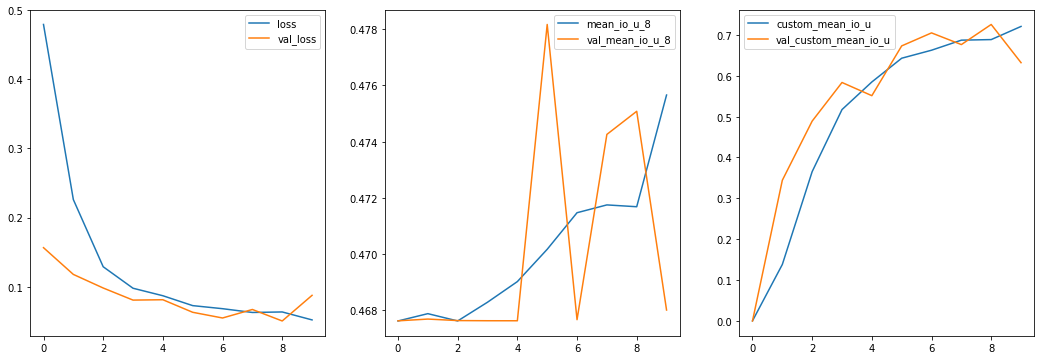

In [61]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
H = history.history
ax[0].plot(H["loss"], label="loss")
ax[0].plot(H["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(H["mean_io_u_8"], label="mean_io_u_8")
ax[1].plot(H["val_mean_io_u_8"], label="val_mean_io_u_8")
ax[1].legend()
ax[2].plot(H["custom_mean_io_u"], label="custom_mean_io_u")
ax[2].plot(H["val_custom_mean_io_u"], label="val_custom_mean_io_u")
ax[2].legend()
plt.show()

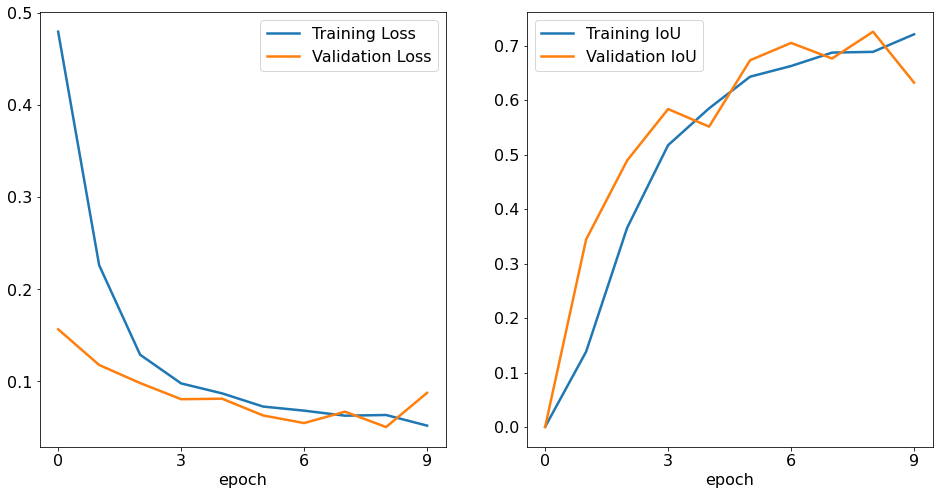

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,2, figsize=(16,8))
H = history.history
lw = 2.5
ax[0].plot(H["loss"], lw=lw, label="Training Loss")
ax[0].plot(H["val_loss"], lw=lw, label="Validation Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks([0,3,6,9])
ax[0].legend()
ax[1].plot(H["custom_mean_io_u"], lw=lw, label="Training IoU")
ax[1].plot(H["val_custom_mean_io_u"], lw=lw, label="Validation IoU")
ax[1].set_xlabel("epoch")
ax[1].set_xticks([0,3,6,9])
ax[1].legend()
plt.savefig("../plots/unet_v4_history.png", dpi=300)

In [62]:
X, y = test_gen.__getitem__(3)

In [63]:
y_pred = unet.predict(X)

In [64]:
custom_iou = CustomMeanIoU()(y, y_pred)
tf.reduce_mean(custom_iou)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6552683>

In [65]:
tf.convert_to_tensor([1,2,3]) > 2

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([False, False,  True])>

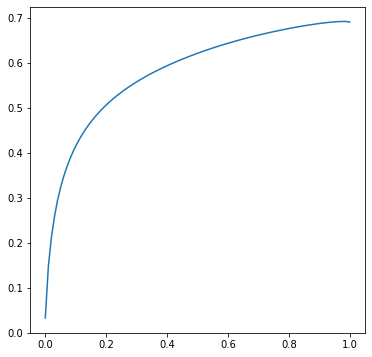

In [66]:
iou = tf.keras.metrics.MeanIoU(num_classes=2)
# iou(y, y_pred>.5)
tresh = np.linspace(0, 1, 100)
iou_score = np.zeros_like(tresh)
for i, t in enumerate(tresh):
    iou_score[i] = iou(y, y_pred>t)

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(tresh, iou_score)
plt.show()

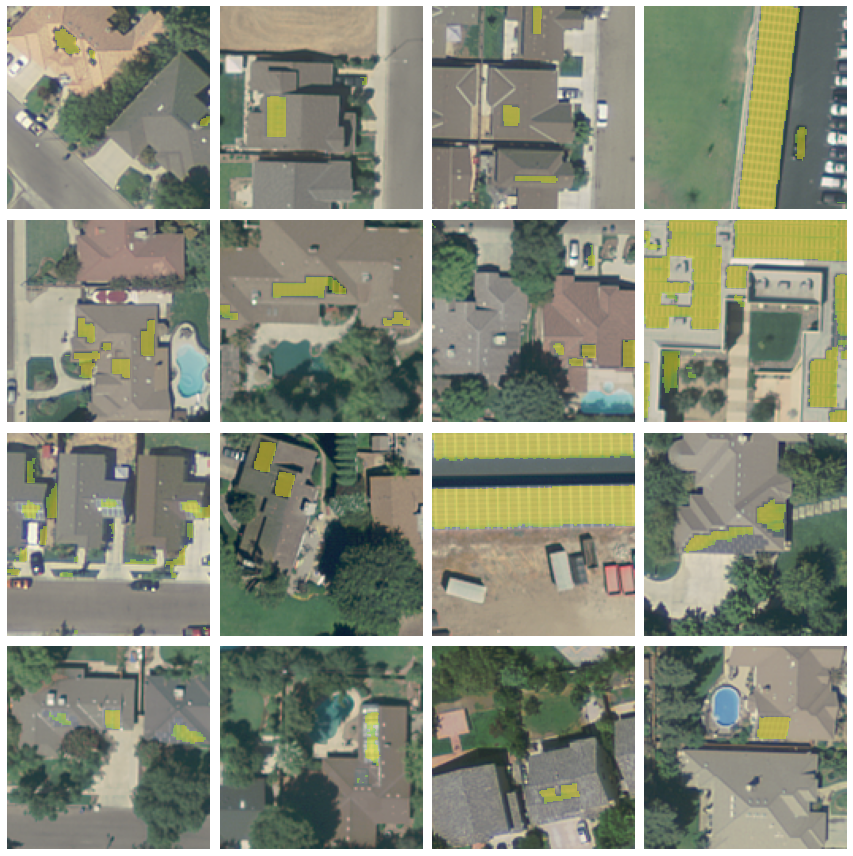

In [67]:
w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(X[w*i+j])
        # ax[i,j].imshow(y[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(y_pred[w*i+j,:,:,0], .8), vmin=0, vmax=1, alpha=.5)
        # ax[i,j].imshow(y_pred[w*i+j,:,:,0], vmin=0, vmax=1, alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
unet = keras.models.load_model("trained_models/Unet/unet_v1.tf")

In [ ]:
image, mask = train_gen.next()
mask_pred = unet.predict(image)

In [ ]:
train_gen = ImageStream("test_dataset/test")
X_test, y_test = train_gen.load_dataset(2000)

In [ ]:
unet.evaluate()

In [ ]:
(mask_pred[w*i+j,:,:,0] > .5).sum()

In [ ]:
w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(image[w*i+j])
        # ax[i,j].imshow(mask[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(mask_pred[w*i+j,:,:,0], .5), alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [22]:
unet.save(r"trained_models\Unet\unet_v2.tf")

INFO:tensorflow:Assets written to: trained_models\Unet\unet_v2.tf\assets
